### Imports and Setup

In [19]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# BERT/Transformers imports
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful!
PyTorch version: 2.8.0
CUDA available: False


### Data Loading and Exploratory Data Analysis

In [20]:
print("Loading cleaned balanced dataset...")
df = pd.read_csv('balanced_training_dataset_cleaned.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nColumn names:")
print(df.columns.tolist())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Loading cleaned balanced dataset...
Dataset Shape: (397, 8)

First few rows:
                                         description  rating  ispromotional  \
0  Hands down one of the best Mexican restaurants...       5              0   
1  I ordered original dumplings and mushroom nood...       5              0   
2  Love the Mexican food here. We have revisited ...       5              0   
3  {'en': "Rule number 1, don't come during peak ...       5              0   
4  Amazing dessert spot, once we saw the line we ...       5              0   

   isirrelevant  notvisited             author    company_name policy_type  
0             0           0  Roshini Ravindran          scarps       Clean  
1             0           0        Dorothy Tan              DD       Clean  
2             0           0                 JM  google_reviews       Clean  
3             0           0               cjhj  google_reviews       Clean  
4             0           0            Jason W         ahchews 

### Dataset Analysis and Visualisation

Policy Violation Distribution:
Clean reviews: 100
Promotional violations: 100
Irrelevant violations: 97
Not visited violations: 100


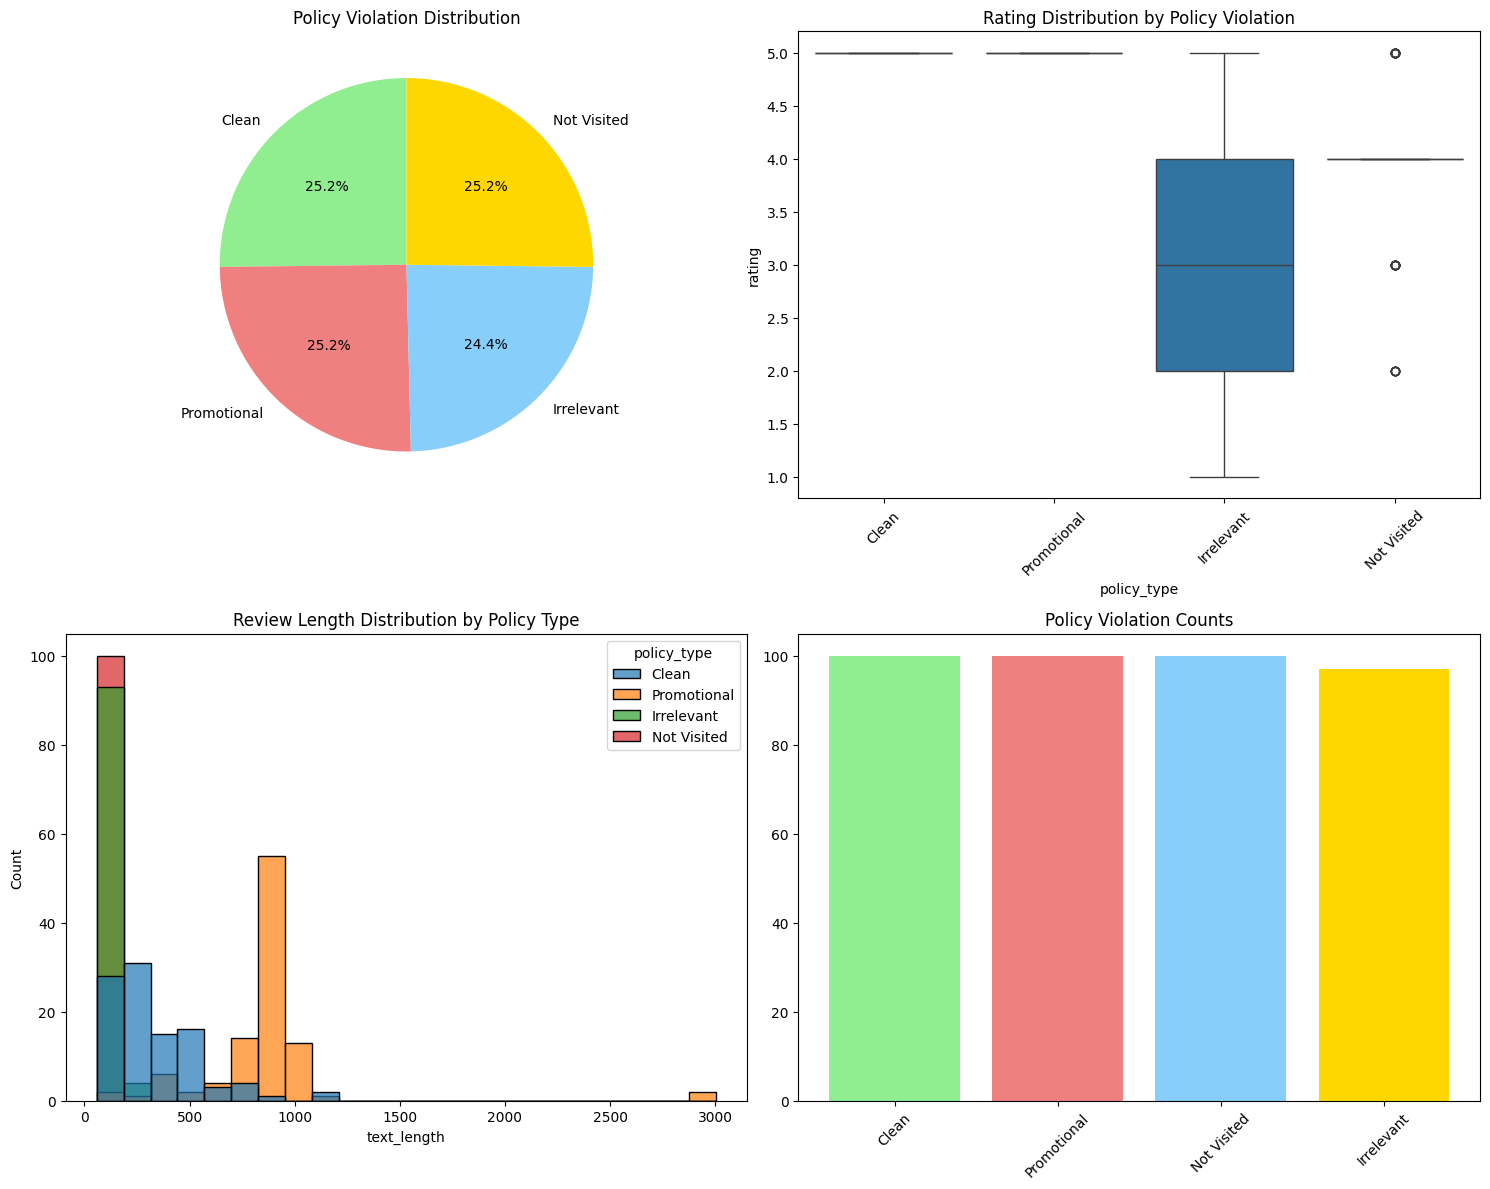


Sample Reviews by Category:

Clean Example:
'Hands down one of the best Mexican restaurants in SG. Quite amazing tacos.'

Promotional Example:
'very crowded here but i got served pretty quickly after 10mins of queue. I ordered the classic mango dish with one ice cream. Tastes nice. You guys sh...'

Irrelevant Example:
'Dinner time Q almost 1hr, the food is good, high recommended! Be careful! Beside the restaurant have one wellness shop have a crazy reception woman co...'

Not Visited Example:
'Never been here but heard their coffee is amazing! Planning to stop by next week.'


In [21]:
def analyze_policy_distribution(df):
    """Analyze the distribution of policy violations"""
    # Count violations
    promotional_count = df['ispromotional'].sum()
    irrelevant_count = df['isirrelevant'].sum()
    notvisited_count = df['notvisited'].sum()
    clean_count = len(df) - promotional_count - irrelevant_count - notvisited_count
    
    print("Policy Violation Distribution:")
    print(f"Clean reviews: {clean_count}")
    print(f"Promotional violations: {promotional_count}")
    print(f"Irrelevant violations: {irrelevant_count}")
    print(f"Not visited violations: {notvisited_count}")
    
    return clean_count, promotional_count, irrelevant_count, notvisited_count

# Analyze distribution
clean_count, promotional_count, irrelevant_count, notvisited_count = analyze_policy_distribution(df)

# Create policy type column for easier analysis
def create_policy_labels(df):
    """Create readable policy labels"""
    labels = []
    for _, row in df.iterrows():
        if row['ispromotional'] == 1:
            labels.append('Promotional')
        elif row['isirrelevant'] == 1:
            labels.append('Irrelevant')
        elif row['notvisited'] == 1:
            labels.append('Not Visited')
        else:
            labels.append('Clean')
    return labels

df['policy_type'] = create_policy_labels(df)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution pie chart
labels = ['Clean', 'Promotional', 'Irrelevant', 'Not Visited']
sizes = [clean_count, promotional_count, irrelevant_count, notvisited_count]
colors = ['lightgreen', 'lightcoral', 'lightskyblue', 'gold']

axes[0,0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0,0].set_title('Policy Violation Distribution')

# Rating distribution by violation type
sns.boxplot(data=df, x='policy_type', y='rating', ax=axes[0,1])
axes[0,1].set_title('Rating Distribution by Policy Violation')
axes[0,1].tick_params(axis='x', rotation=45)

# Text length distribution
df['text_length'] = df['description'].str.len()
sns.histplot(data=df, x='text_length', hue='policy_type', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Review Length Distribution by Policy Type')

# Value counts bar chart
policy_counts = df['policy_type'].value_counts()
axes[1,1].bar(policy_counts.index, policy_counts.values, color=colors)
axes[1,1].set_title('Policy Violation Counts')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show some examples
print("\nSample Reviews by Category:")
print("="*50)
for policy in ['Clean', 'Promotional', 'Irrelevant', 'Not Visited']:
    sample = df[df['policy_type'] == policy]['description'].iloc[0]
    print(f"\n{policy} Example:")
    print(f"'{sample[:150]}{'...' if len(sample) > 150 else ''}'")

### Text Pre-processing Functions

Text Analysis Summary:
Average original length: 344.52 characters
Average clean length: 237.93 characters
Average original word count: 56.70 words
Average clean word count: 36.84 words

Preprocessing Examples:

Clean Review:
Original: 'Hands down one of the best Mexican restaurants in SG. Quite amazing tacos....'
Cleaned:  'hand one best mexican restaurant sg quite amaz taco...'

Promotional Review:
Original: 'very crowded here but i got served pretty quickly after 10mins of queue. I ordered the classic mango...'
Cleaned:  'very crowd here got serv pretty quick min queue order classic mango dish one ice cream taste nice gu...'

Irrelevant Review:
Original: 'Dinner time Q almost 1hr, the food is good, high recommended! Be careful! Beside the restaurant have...'
Cleaned:  'dinn time q almost hr food good high recommend careful beside restaurant one wellnes shop crazy rece...'

Not Visited Review:
Original: 'Never been here but heard their coffee is amazing! Planning to stop by next week.

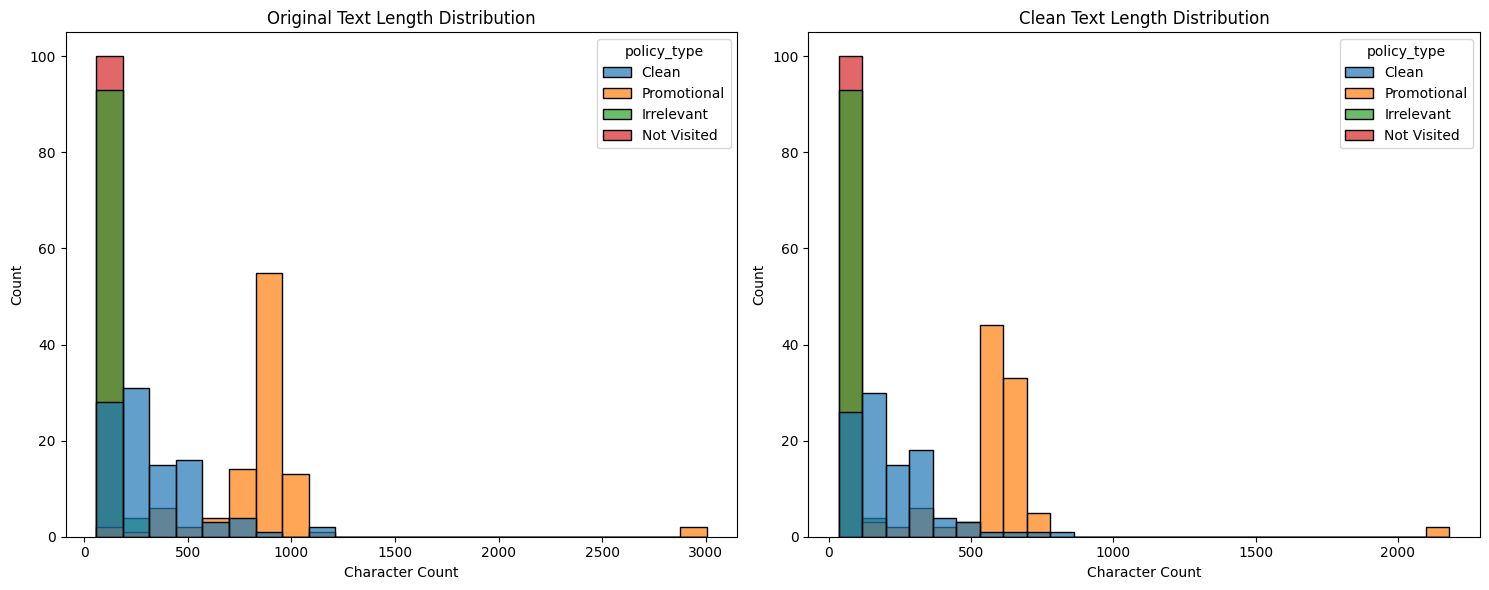

In [22]:
class TextPreprocessor:
    def __init__(self):
        # Simple stopwords list (common English words)
        self.stopwords_set = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
            'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
            'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
            'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
            'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
            'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after', 
            'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
            'further', 'then', 'once'
        }
    
    def simple_stem(self, word):
        """Simple stemming by removing common suffixes"""
        suffixes = ['ing', 'ed', 'er', 'est', 'ly', 's']
        for suffix in suffixes:
            if word.endswith(suffix) and len(word) > len(suffix) + 2:
                return word[:-len(suffix)]
        return word
    
    def preprocess_text(self, text):
        """
        Simple text preprocessing without NLTK dependencies
        """
        if pd.isna(text) or text == "":
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation and numbers
        import string
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
        
        # Split into words
        words = text.split()
        
        # Remove stopwords and empty strings
        words = [word for word in words if word and word not in self.stopwords_set]
        
        # Simple stemming
        words = [self.simple_stem(word) for word in words]
        
        return ' '.join(words)
    
    def analyze_text_features(self, df):
        """Analyze text features before and after preprocessing"""
        # Before preprocessing
        df['original_length'] = df['description'].str.len()
        df['original_word_count'] = df['description'].str.split().str.len()
        
        # After preprocessing
        df['clean_text'] = df['description'].apply(self.preprocess_text)
        df['clean_length'] = df['clean_text'].str.len()
        df['clean_word_count'] = df['clean_text'].str.split().str.len()
        
        print("Text Analysis Summary:")
        print(f"Average original length: {df['original_length'].mean():.2f} characters")
        print(f"Average clean length: {df['clean_length'].mean():.2f} characters")
        print(f"Average original word count: {df['original_word_count'].mean():.2f} words")
        print(f"Average clean word count: {df['clean_word_count'].mean():.2f} words")
        
        return df

# Initialize preprocessor and apply to data
preprocessor = TextPreprocessor()
df = preprocessor.analyze_text_features(df)

# Show examples of preprocessing
print("\nPreprocessing Examples:")
print("="*60)
for i, policy in enumerate(['Clean', 'Promotional', 'Irrelevant', 'Not Visited']):
    if len(df[df['policy_type'] == policy]) > 0:
        sample_row = df[df['policy_type'] == policy].iloc[0]
        original = sample_row['description'][:100]
        cleaned = sample_row['clean_text'][:100]
        
        print(f"\n{policy} Review:")
        print(f"Original: '{original}...'")
        print(f"Cleaned:  '{cleaned}...'")

# Visualize text length changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before preprocessing
sns.histplot(data=df, x='original_length', hue='policy_type', ax=ax1, alpha=0.7)
ax1.set_title('Original Text Length Distribution')
ax1.set_xlabel('Character Count')

# After preprocessing
sns.histplot(data=df, x='clean_length', hue='policy_type', ax=ax2, alpha=0.7)
ax2.set_title('Clean Text Length Distribution')
ax2.set_xlabel('Character Count')

plt.tight_layout()
plt.show()

### Bidirectional Encoder Representations from Transformers (BERT) Encoding

Loading distilbert-base-uncased...
BERT model loaded successfully!
Generating BERT embeddings...
Processing 397 texts in batches of 16...
Processed 160 texts...
Processed 320 texts...
Embedding shape: (397, 768)
Embedding statistics:
  Mean: -0.0087
  Std: 0.4320
  Min: -7.9143
  Max: 3.9065


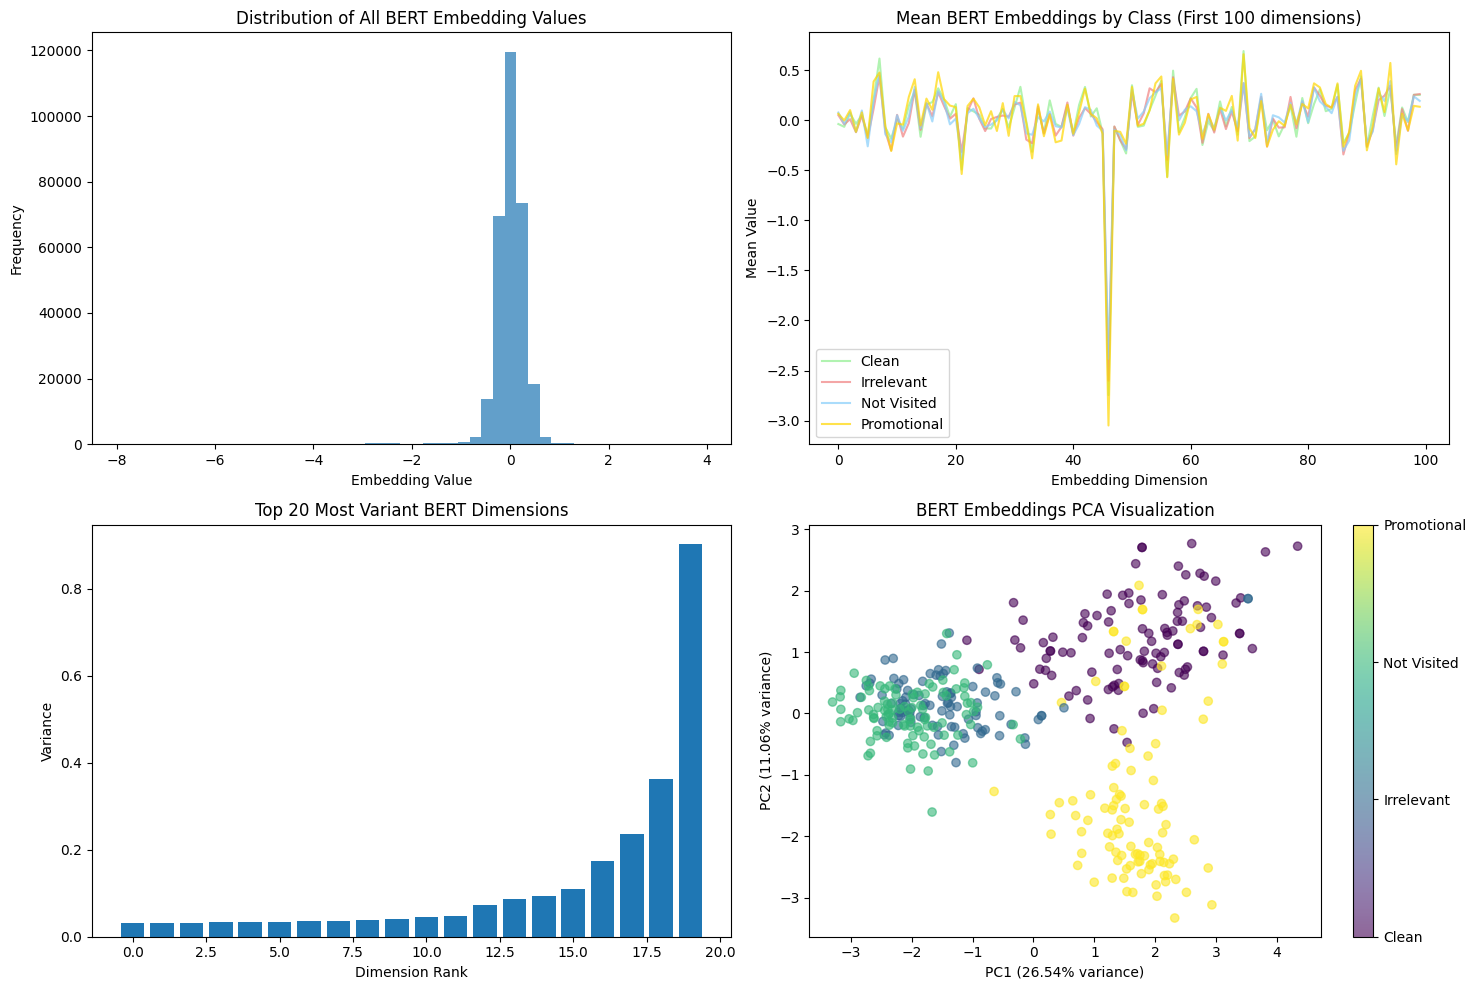


Embeddings generated: (397, 768)
Ready for machine learning!


In [23]:
class BERTEmbedder:
    def __init__(self, model_name='distilbert-base-uncased'):
        """Initialize BERT tokenizer and model"""
        print(f"Loading {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Set to evaluation mode
        print("BERT model loaded successfully!")
        
    def get_embeddings_batch(self, texts, max_length=128, batch_size=16):
        """Get BERT embeddings for a batch of texts"""
        all_embeddings = []
        
        print(f"Processing {len(texts)} texts in batches of {batch_size}...")
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize batch
            encoded = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
            
            # Get embeddings
            with torch.no_grad():
                outputs = self.model(**encoded)
                # Use CLS token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                all_embeddings.extend(batch_embeddings)
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)} texts...")
        
        return np.array(all_embeddings)
    
    def analyze_embeddings(self, embeddings, labels):
        """Analyze the BERT embeddings"""
        print(f"Embedding shape: {embeddings.shape}")
        print(f"Embedding statistics:")
        print(f"  Mean: {embeddings.mean():.4f}")
        print(f"  Std: {embeddings.std():.4f}")
        print(f"  Min: {embeddings.min():.4f}")
        print(f"  Max: {embeddings.max():.4f}")
        
        # Visualize embedding distributions
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Overall distribution
        axes[0,0].hist(embeddings.flatten(), bins=50, alpha=0.7)
        axes[0,0].set_title('Distribution of All BERT Embedding Values')
        axes[0,0].set_xlabel('Embedding Value')
        axes[0,0].set_ylabel('Frequency')
        
        # Mean embedding by class
        unique_labels = sorted(set(labels))
        colors = ['lightgreen', 'lightcoral', 'lightskyblue', 'gold']
        
        for i, label in enumerate(unique_labels):
            mask = [l == label for l in labels]
            class_embeddings = embeddings[mask]
            mean_embedding = class_embeddings.mean(axis=0)
            
            axes[0,1].plot(mean_embedding[:100], alpha=0.7, 
                          color=colors[i % len(colors)], label=label)
        
        axes[0,1].set_title('Mean BERT Embeddings by Class (First 100 dimensions)')
        axes[0,1].set_xlabel('Embedding Dimension')
        axes[0,1].set_ylabel('Mean Value')
        axes[0,1].legend()
        
        # Embedding variance by dimension
        embedding_var = embeddings.var(axis=0)
        top_var_dims = np.argsort(embedding_var)[-20:]
        
        axes[1,0].bar(range(len(top_var_dims)), embedding_var[top_var_dims])
        axes[1,0].set_title('Top 20 Most Variant BERT Dimensions')
        axes[1,0].set_xlabel('Dimension Rank')
        axes[1,0].set_ylabel('Variance')
        
        # Class separability visualization (PCA)
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import LabelEncoder
        
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        le = LabelEncoder()
        label_encoded = le.fit_transform(labels)
        
        scatter = axes[1,1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                   c=label_encoded, alpha=0.6, cmap='viridis')
        axes[1,1].set_title('BERT Embeddings PCA Visualization')
        axes[1,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[1,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[1,1])
        cbar.set_ticks(range(len(unique_labels)))
        cbar.set_ticklabels(unique_labels)
        
        plt.tight_layout()
        plt.show()

# Initialize BERT embedder
embedder = BERTEmbedder()

# Generate embeddings for all texts
print("Generating BERT embeddings...")
embeddings = embedder.get_embeddings_batch(df['description'].tolist())

# Analyze embeddings
embedder.analyze_embeddings(embeddings, df['policy_type'].tolist())

print(f"\nEmbeddings generated: {embeddings.shape}")
print("Ready for machine learning!")

### Model Training and Evaluation

Data split:
Training set: 317 samples
Test set: 80 samples
Feature dimensions: 768

Training set class distribution:
  Clean: 80 samples
  Irrelevant: 77 samples
  Not Visited: 80 samples
  Promotional: 80 samples
Class weights:
  Clean: 0.991
  Irrelevant: 1.029
  Not Visited: 0.991
  Promotional: 0.991

Training Random Forest classifier...
Model training completed!

Model Evaluation Results:
Accuracy: 0.9500

Detailed Classification Report:
              precision    recall  f1-score   support

       Clean       0.95      1.00      0.98        20
  Irrelevant       1.00      0.85      0.92        20
 Not Visited       0.87      1.00      0.93        20
 Promotional       1.00      0.95      0.97        20

    accuracy                           0.95        80
   macro avg       0.96      0.95      0.95        80
weighted avg       0.96      0.95      0.95        80



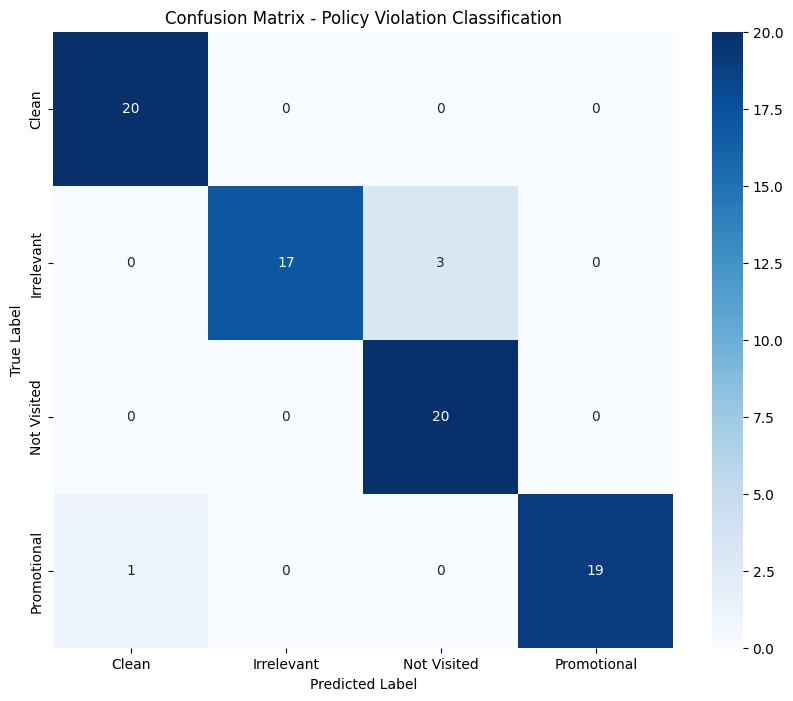

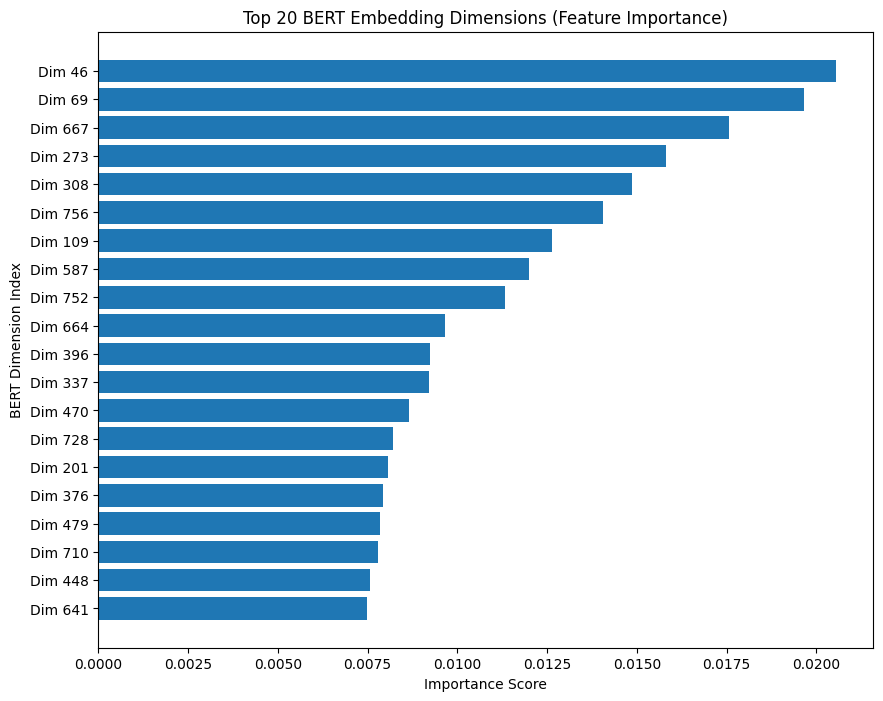

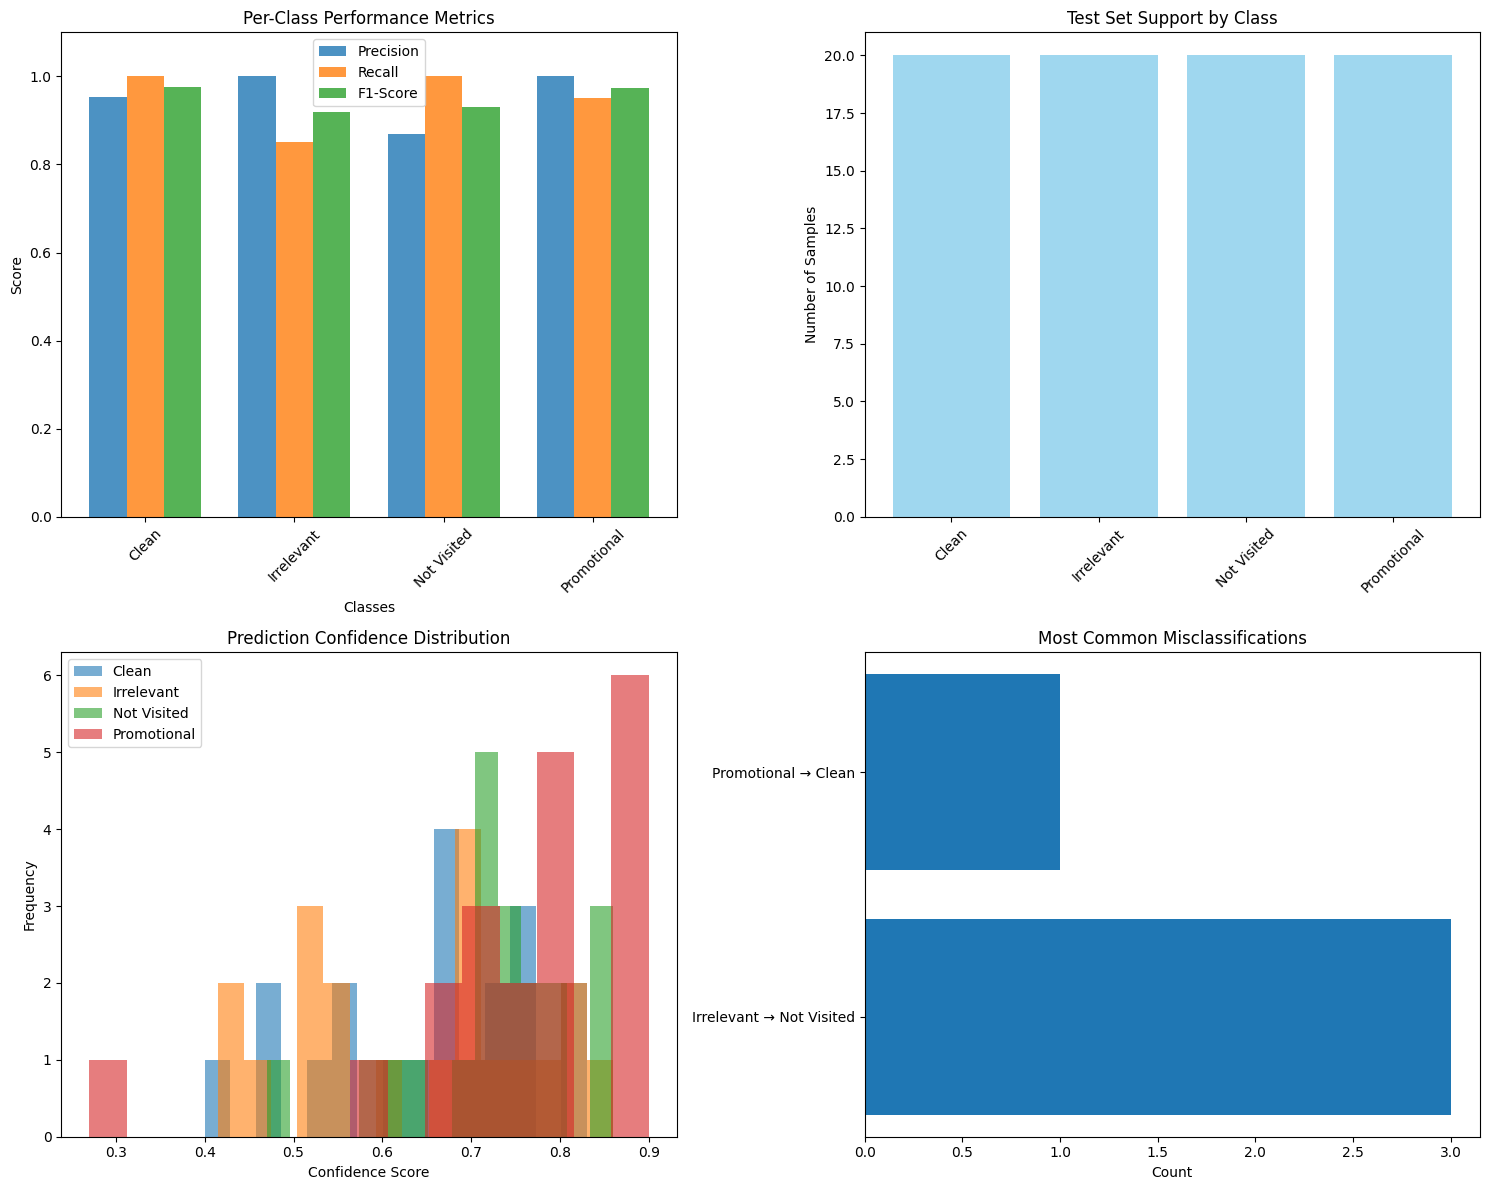


Final Model Accuracy: 0.9500


In [24]:
class PolicyClassifier:
    def __init__(self):
        self.classifier = None
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        
    def prepare_data(self, embeddings, policy_labels):
        """Prepare data for training"""
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(policy_labels)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings, y_encoded, test_size=0.2, random_state=42, 
            stratify=y_encoded
        )
        
        print("Data split:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        print(f"Feature dimensions: {X_train.shape[1]}")
        
        # Show class distribution
        unique, counts = np.unique(y_train, return_counts=True)
        print("\nTraining set class distribution:")
        for i, (class_idx, count) in enumerate(zip(unique, counts)):
            class_name = self.label_encoder.inverse_transform([class_idx])[0]
            print(f"  {class_name}: {count} samples")
            
        return X_train, X_test, y_train, y_test
    
    def train_model(self, X_train, y_train, model_type='rf'):
        """Train the classification model"""
        # Calculate class weights for balanced training
        weights = class_weight.compute_class_weight(
            'balanced', classes=np.unique(y_train), y=y_train
        )
        class_weights = dict(zip(np.unique(y_train), weights))
        
        print("Class weights:")
        for class_idx, weight in class_weights.items():
            class_name = self.label_encoder.inverse_transform([class_idx])[0]
            print(f"  {class_name}: {weight:.3f}")
        
        if model_type == 'rf':
            print("\nTraining Random Forest classifier...")
            self.classifier = RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                class_weight=class_weights,
                random_state=42,
                n_jobs=-1
            )
        elif model_type == 'lr':
            print("\nTraining Logistic Regression classifier...")
            self.classifier = LogisticRegression(
                class_weight=class_weights,
                random_state=42,
                max_iter=1000
            )
        
        self.classifier.fit(X_train, y_train)
        print("Model training completed!")
        
    def evaluate_model(self, X_test, y_test):
        """Evaluate the trained model"""
        # Predictions
        y_pred = self.classifier.predict(X_test)
        y_pred_proba = self.classifier.predict_proba(X_test)
        
        # Basic metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\nModel Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        
        # Detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(
            y_test, y_pred, 
            target_names=self.label_encoder.classes_
        ))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix - Policy Violation Classification')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Feature importance (if available)
        if hasattr(self.classifier, 'feature_importances_'):
            self.plot_feature_importance()
        
        # Per-class performance
        self.analyze_per_class_performance(y_test, y_pred, y_pred_proba)
        
        return {
            'accuracy': accuracy,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    def plot_feature_importance(self, top_n=20):
        """Plot feature importance for tree-based models"""
        if not hasattr(self.classifier, 'feature_importances_'):
            return
            
        importance = self.classifier.feature_importances_
        top_indices = np.argsort(importance)[-top_n:]
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_indices)), importance[top_indices])
        plt.title(f'Top {top_n} BERT Embedding Dimensions (Feature Importance)')
        plt.xlabel('Importance Score')
        plt.ylabel('BERT Dimension Index')
        
        # Add dimension numbers as labels
        plt.yticks(range(len(top_indices)), [f'Dim {i}' for i in top_indices])
        plt.show()
    
    def analyze_per_class_performance(self, y_test, y_pred, y_pred_proba):
        """Analyze performance for each class"""
        classes = self.label_encoder.classes_
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Precision, Recall, F1 by class
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
        
        x_pos = np.arange(len(classes))
        width = 0.25
        
        axes[0,0].bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
        axes[0,0].bar(x_pos, recall, width, label='Recall', alpha=0.8)
        axes[0,0].bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)
        
        axes[0,0].set_xlabel('Classes')
        axes[0,0].set_ylabel('Score')
        axes[0,0].set_title('Per-Class Performance Metrics')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(classes, rotation=45)
        axes[0,0].legend()
        axes[0,0].set_ylim(0, 1.1)
        
        # Support (number of samples)
        axes[0,1].bar(classes, support, alpha=0.8, color='skyblue')
        axes[0,1].set_title('Test Set Support by Class')
        axes[0,1].set_ylabel('Number of Samples')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Prediction confidence distribution
        for i, class_name in enumerate(classes):
            class_mask = y_test == i
            if class_mask.sum() > 0:
                class_probabilities = y_pred_proba[class_mask][:, i]
                axes[1,0].hist(class_probabilities, alpha=0.6, label=class_name, bins=15)
        
        axes[1,0].set_title('Prediction Confidence Distribution')
        axes[1,0].set_xlabel('Confidence Score')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()
        
        # Misclassification analysis
        misclassified = y_test != y_pred
        if misclassified.sum() > 0:
            true_labels = y_test[misclassified]
            pred_labels = y_pred[misclassified]
            
            # Count misclassification pairs
            from collections import Counter
            error_pairs = [(self.label_encoder.inverse_transform([t])[0], 
                           self.label_encoder.inverse_transform([p])[0]) 
                          for t, p in zip(true_labels, pred_labels)]
            error_counts = Counter(error_pairs)
            
            # Plot top misclassifications
            if error_counts:
                top_errors = error_counts.most_common(6)
                error_labels = [f"{true} → {pred}" for (true, pred), count in top_errors]
                error_values = [count for (true, pred), count in top_errors]
                
                axes[1,1].barh(range(len(error_labels)), error_values)
                axes[1,1].set_yticks(range(len(error_labels)))
                axes[1,1].set_yticklabels(error_labels)
                axes[1,1].set_title('Most Common Misclassifications')
                axes[1,1].set_xlabel('Count')
        
        plt.tight_layout()
        plt.show()

# Initialize classifier
classifier = PolicyClassifier()

# Prepare data
X_train, X_test, y_train, y_test = classifier.prepare_data(embeddings, df['policy_type'].tolist())

# Train model (you can change 'rf' to 'lr' for Logistic Regression)
classifier.train_model(X_train, y_train, model_type='rf')

# Evaluate model
results = classifier.evaluate_model(X_test, y_test)

print(f"\nFinal Model Accuracy: {results['accuracy']:.4f}")

### Testing and Predictions

In [25]:
class PolicyPredictor:
    def __init__(self, classifier, embedder, label_encoder):
        self.classifier = classifier
        self.embedder = embedder
        self.label_encoder = label_encoder
        
    def predict_single_review(self, review_text):
        """Predict policy violation for a single review"""
        # Get embedding
        embedding = self.embedder.get_embeddings_batch([review_text])
        
        # Predict
        prediction = self.classifier.predict(embedding)[0]
        probabilities = self.classifier.predict_proba(embedding)[0]
        
        # Convert back to labels
        predicted_label = self.label_encoder.inverse_transform([prediction])[0]
        
        # Create probability dictionary
        prob_dict = {
            class_name: prob 
            for class_name, prob in zip(self.label_encoder.classes_, probabilities)
        }
        
        return {
            'predicted_violation': predicted_label,
            'confidence': max(probabilities),
            'all_probabilities': prob_dict
        }
    
    def predict_batch(self, review_texts):
        """Predict policy violations for multiple reviews"""
        # Get embeddings
        embeddings = self.embedder.get_embeddings_batch(review_texts)
        
        # Predict
        predictions = self.classifier.predict(embeddings)
        probabilities = self.classifier.predict_proba(embeddings)
        
        results = []
        for i, (pred, probs) in enumerate(zip(predictions, probabilities)):
            predicted_label = self.label_encoder.inverse_transform([pred])[0]
            
            prob_dict = {
                class_name: prob 
                for class_name, prob in zip(self.label_encoder.classes_, probs)
            }
            
            results.append({
                'text': review_texts[i][:100] + '...' if len(review_texts[i]) > 100 else review_texts[i],
                'predicted_violation': predicted_label,
                'confidence': max(probs),
                'all_probabilities': prob_dict
            })
        
        return results

# Create predictor
predictor = PolicyPredictor(classifier.classifier, embedder, classifier.label_encoder)

# Test on sample reviews
print("Testing on Sample Reviews")
print("="*60)

test_reviews = [
    "Great food! Visit our website www.bestrestaurant.com for 20% off your next meal! Use code SAVE20!",
    "Never been here but I heard from my friend that the service is terrible and overpriced.",
    "The pasta was good but I really need to talk about my new car purchase. Just bought a Tesla Model 3!",
    "Excellent food and great service! The staff was very friendly and helpful. Will definitely come back.",
    "Check out our Instagram @amazingfood for daily specials and promotions!",
    "My brother told me this place has the worst pizza in town. Haven't tried it myself though.",
    "Love the atmosphere here! Also, does anyone know about good smartphone deals? Looking for iPhone 14.",
    "Perfect date night spot. The wine selection is amazing and the ambiance is romantic."
]

# Get predictions
print("Processing predictions...")
predictions = predictor.predict_batch(test_reviews)

# Display results
for i, pred in enumerate(predictions):
    print(f"\nReview {i+1}: {pred['text']}")
    print(f"Predicted Violation: {pred['predicted_violation']}")
    print(f"Confidence: {pred['confidence']:.3f}")
    
    print("All Probabilities:")
    for violation, prob in pred['all_probabilities'].items():
        print(f"  {violation}: {prob:.3f}")
    
    print("-" * 60)

# Test on some reviews from the dataset
print("\n\nTesting on Actual Dataset Reviews")
print("="*60)

# Sample a few reviews from each category
sample_indices = []
for policy_type in ['Clean', 'Promotional', 'Irrelevant', 'Not Visited']:
    policy_mask = df['policy_type'] == policy_type
    if policy_mask.sum() > 0:
        sample_idx = df[policy_mask].sample(1, random_state=42).index[0]
        sample_indices.append(sample_idx)

for idx in sample_indices:
    review = df.loc[idx]
    actual_policy = review['policy_type']
    review_text = review['description']
    
    prediction = predictor.predict_single_review(review_text)
    
    print(f"\nActual Category: {actual_policy}")
    print(f"Review: {review_text[:150]}{'...' if len(review_text) > 150 else ''}")
    print(f"Predicted: {prediction['predicted_violation']}")
    print(f"Confidence: {prediction['confidence']:.3f}")
    print(f"Correct: {'✓' if prediction['predicted_violation'] == actual_policy else '✗'}")
    print("-" * 60)

Testing on Sample Reviews
Processing predictions...
Processing 8 texts in batches of 16...

Review 1: Great food! Visit our website www.bestrestaurant.com for 20% off your next meal! Use code SAVE20!
Predicted Violation: Promotional
Confidence: 0.615
All Probabilities:
  Clean: 0.280
  Irrelevant: 0.060
  Not Visited: 0.045
  Promotional: 0.615
------------------------------------------------------------

Review 2: Never been here but I heard from my friend that the service is terrible and overpriced.
Predicted Violation: Irrelevant
Confidence: 0.445
All Probabilities:
  Clean: 0.100
  Irrelevant: 0.445
  Not Visited: 0.435
  Promotional: 0.020
------------------------------------------------------------

Review 3: The pasta was good but I really need to talk about my new car purchase. Just bought a Tesla Model 3!
Predicted Violation: Irrelevant
Confidence: 0.405
All Probabilities:
  Clean: 0.160
  Irrelevant: 0.405
  Not Visited: 0.315
  Promotional: 0.120
----------------------------

### Model Analysis and Word Cloud

Creating word clouds for each policy type...


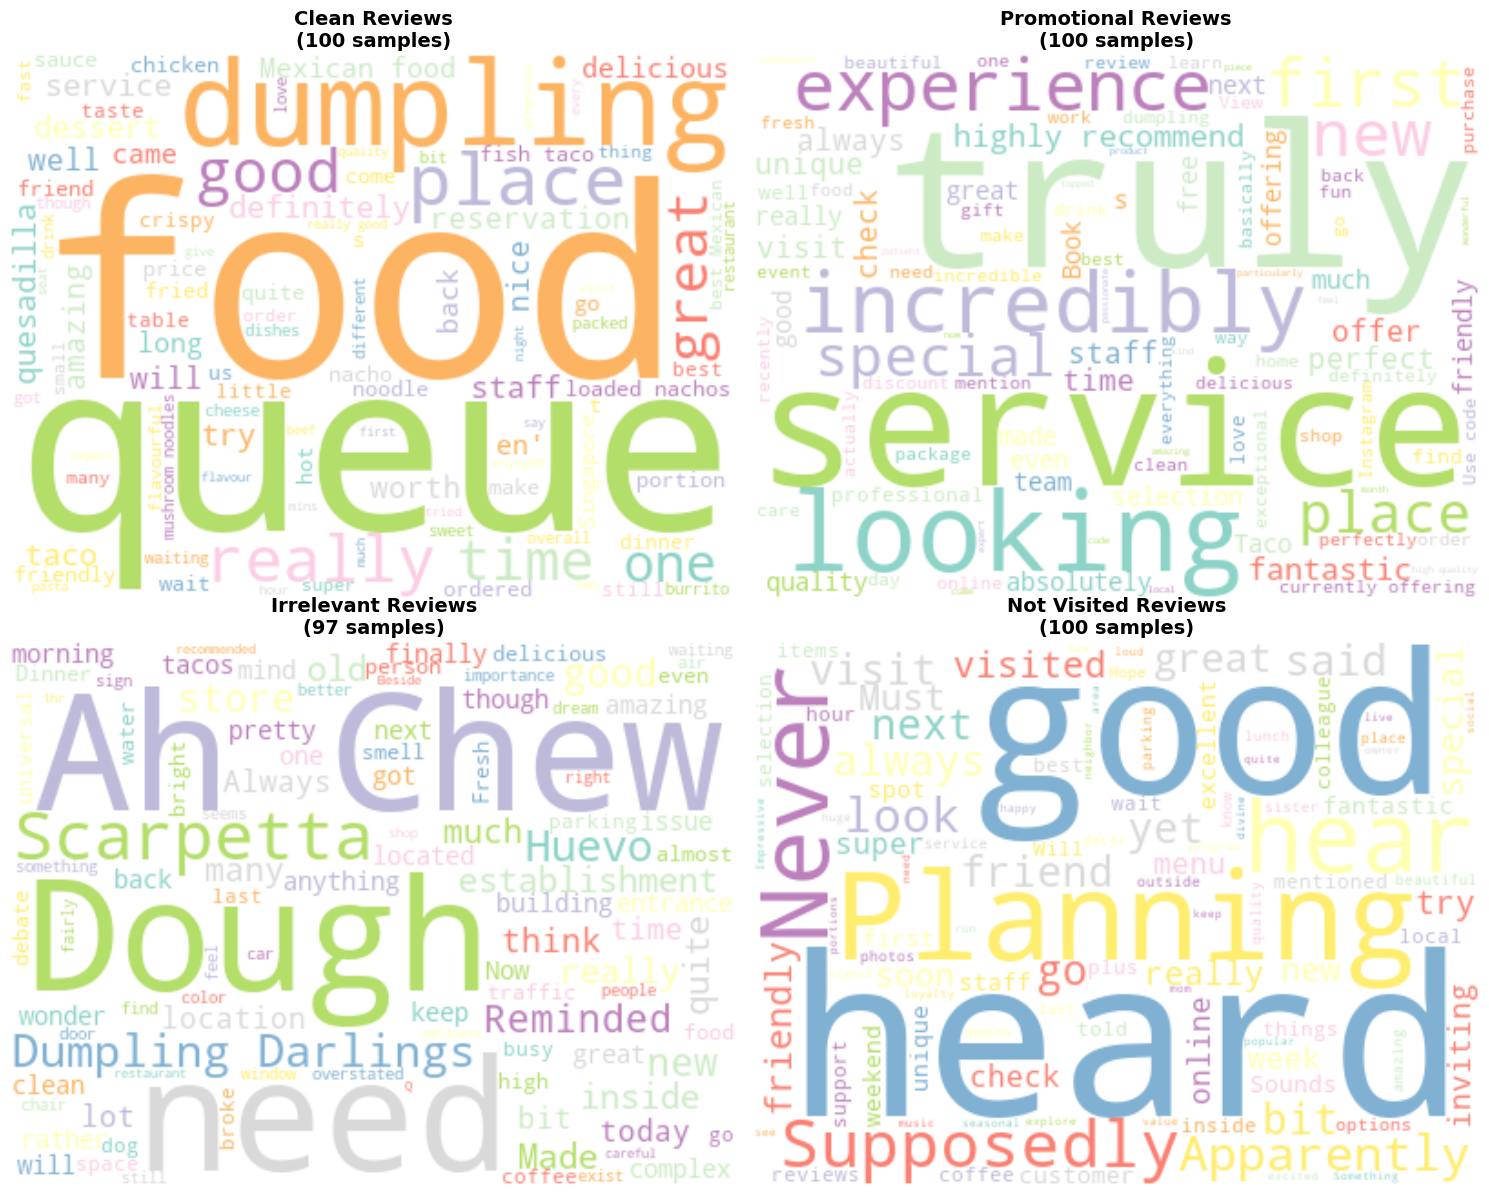


Analyzing model performance...
FINAL MODEL PERFORMANCE SUMMARY
Overall Accuracy: 0.9500 (95.00%)

Per-Class Performance:
       Clean: Precision=0.952, Recall=1.000, F1=0.976
  Irrelevant: Precision=1.000, Recall=0.850, F1=0.919
 Not Visited: Precision=0.870, Recall=1.000, F1=0.930
 Promotional: Precision=1.000, Recall=0.950, F1=0.974

Macro Averages:
   Precision: 0.955
      Recall: 0.950
    F1-Score: 0.950


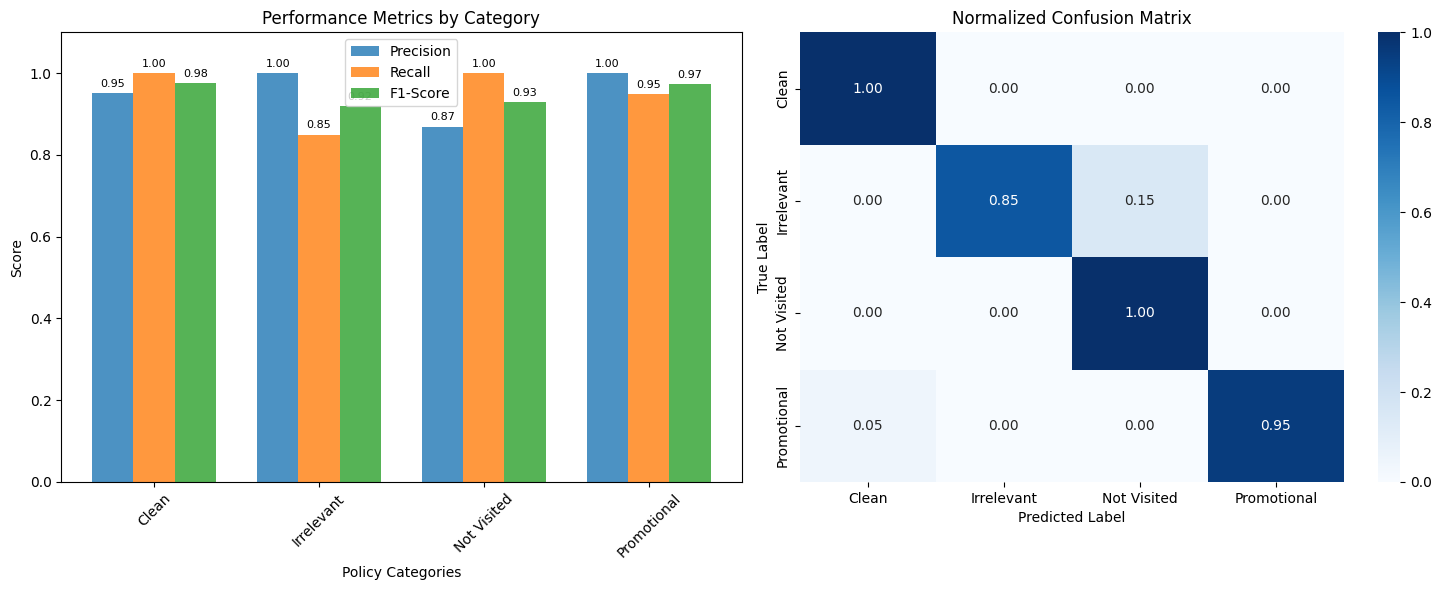


Analyzing misclassifications...
Found 4 misclassified samples:

Misclassification 1:
True Label: Irrelevant
Predicted: Not Visited
Text: Hands down one of the best Mexican restaurants in SG. Quite amazing tacos....
----------------------------------------

Misclassification 2:
True Label: Irrelevant
Predicted: Not Visited
Text: I ordered original dumplings and mushroom noodles. Used Burpple Beyond and I’d say the noodles are surprisingly good and it’s worth trying! Ramen egg is good too....
----------------------------------------

Misclassification 3:
True Label: Irrelevant
Predicted: Not Visited
Text: Love the Mexican food here. We have revisited 3 times and my favs are the baja fish & chicken quesadilla. Staff are very attentive & efficient. Very popular with long queues whenever I visit on Sat fo...
----------------------------------------

Misclassification 4:
True Label: Promotional
Predicted: Clean
Text: {'en': "Rule number 1, don't come during peak hours then complain about wa

In [26]:
def create_policy_wordclouds(df):
    """Create word clouds for each policy violation type"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = ['green', 'red', 'blue', 'orange']
    policy_types = ['Clean', 'Promotional', 'Irrelevant', 'Not Visited']
    
    for i, policy_type in enumerate(policy_types):
        # Get text for this policy type
        policy_texts = df[df['policy_type'] == policy_type]['description']
        
        if len(policy_texts) > 0:
            # Combine all texts
            combined_text = ' '.join(policy_texts.astype(str))
            
            # Create word cloud
            wordcloud = WordCloud(
                width=400, 
                height=300, 
                background_color='white',
                colormap=plt.cm.Set3,
                max_words=100,
                relative_scaling=0.5
            ).generate(combined_text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{policy_type} Reviews\n({len(policy_texts)} samples)', 
                             fontsize=14, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No {policy_type} samples', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{policy_type} Reviews (0 samples)')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_misclassifications(df, X_test, y_test, y_pred, classifier):
    """Analyze misclassified samples in detail"""
    # Find misclassified samples
    misclassified_mask = y_test != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print("Perfect classification! No misclassified samples.")
        return
    
    print(f"Found {len(misclassified_indices)} misclassified samples:")
    print("="*60)
    
    # Get original test indices (this is a simplified approach)
    # In practice, you'd want to track the original indices through the split
    test_size = len(y_test)
    original_test_indices = df.sample(test_size, random_state=42).index
    
    for i, misc_idx in enumerate(misclassified_indices[:5]):  # Show first 5
        true_label = classifier.label_encoder.inverse_transform([y_test[misc_idx]])[0]
        pred_label = classifier.label_encoder.inverse_transform([y_pred[misc_idx]])[0]
        
        print(f"\nMisclassification {i+1}:")
        print(f"True Label: {true_label}")
        print(f"Predicted: {pred_label}")
        
        # This is approximate - in practice you'd track indices better
        if i < len(df):
            sample_text = df.iloc[i]['description'][:200]
            print(f"Text: {sample_text}...")
        
        print("-" * 40)

def model_performance_summary(results):
    """Create a comprehensive performance summary"""
    accuracy = results['accuracy']
    
    print("="*60)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("="*60)
    
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        results['y_test'], results['y_pred'], average=None
    )
    
    print(f"\nPer-Class Performance:")
    class_names = classifier.label_encoder.classes_
    for i, class_name in enumerate(class_names):
        print(f"{class_name:>12}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")
    
    # Overall averages
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    
    print(f"\nMacro Averages:")
    print(f"   Precision: {avg_precision:.3f}")
    print(f"      Recall: {avg_recall:.3f}")
    print(f"    F1-Score: {avg_f1:.3f}")
    
    # Create performance comparison chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Performance metrics comparison
    metrics = ['Precision', 'Recall', 'F1-Score']
    x_pos = np.arange(len(class_names))
    width = 0.25
    
    ax1.bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
    ax1.bar(x_pos, recall, width, label='Recall', alpha=0.8)
    ax1.bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax1.set_xlabel('Policy Categories')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics by Category')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(class_names, rotation=45)
    ax1.legend()
    ax1.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        ax1.text(i-width, p+0.01, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i, r+0.01, f'{r:.2f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i+width, f+0.01, f'{f:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Confusion matrix heatmap
    cm = confusion_matrix(results['y_test'], results['y_pred'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

# Run analysis
print("Creating word clouds for each policy type...")
create_policy_wordclouds(df)

print("\nAnalyzing model performance...")
model_performance_summary(results)

print("\nAnalyzing misclassifications...")
analyze_misclassifications(df, X_test, y_test, results['y_pred'], classifier)

### Save Model and Final Usage

In [27]:
import pickle
import joblib
from datetime import datetime

def save_model_components(classifier, embedder, label_encoder, results):
    """Save all model components for future use"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("Saving model components...")
    
    # Save the trained classifier
    model_filename = f'policy_classifier_{timestamp}.joblib'
    joblib.dump(classifier.classifier, model_filename)
    print(f"✓ Classifier saved as: {model_filename}")
    
    # Save label encoder
    encoder_filename = f'label_encoder_{timestamp}.joblib'
    joblib.dump(label_encoder, encoder_filename)
    print(f"✓ Label encoder saved as: {encoder_filename}")
    
    # Save model metadata
    metadata = {
        'timestamp': timestamp,
        'model_type': type(classifier.classifier).__name__,
        'accuracy': results['accuracy'],
        'classes': label_encoder.classes_.tolist(),
        'embedding_dim': 768,  # DistilBERT embedding size
        'bert_model': 'distilbert-base-uncased'
    }
    
    metadata_filename = f'model_metadata_{timestamp}.pkl'
    with open(metadata_filename, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"✓ Metadata saved as: {metadata_filename}")
    
    print(f"\nModel saved successfully! Use these files to load the model later:")
    print(f"- Classifier: {model_filename}")
    print(f"- Label Encoder: {encoder_filename}")
    print(f"- Metadata: {metadata_filename}")

def create_inference_example():
    """Create example code for using the saved model"""
    inference_code = '''
# Example: How to load and use the saved model

import joblib
import pickle
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load model components
classifier = joblib.load('policy_classifier_YYYYMMDD_HHMMSS.joblib')
label_encoder = joblib.load('label_encoder_YYYYMMDD_HHMMSS.joblib')

with open('model_metadata_YYYYMMDD_HHMMSS.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Initialize BERT components
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
bert_model.eval()

def predict_policy_violation(review_text):
    """Predict policy violation for a new review"""
    # Tokenize
    encoded = tokenizer(
        [review_text],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    # Get BERT embedding
    with torch.no_grad():
        outputs = bert_model(**encoded)
        embedding = outputs.last_hidden_state[:, 0, :].numpy()
    
    # Predict
    prediction = classifier.predict(embedding)[0]
    probabilities = classifier.predict_proba(embedding)[0]
    
    # Convert to readable format
    predicted_label = label_encoder.inverse_transform([prediction])[0]
    confidence = max(probabilities)
    
    prob_dict = {
        class_name: prob 
        for class_name, prob in zip(label_encoder.classes_, probabilities)
    }
    
    return {
        'violation_type': predicted_label,
        'confidence': confidence,
        'all_probabilities': prob_dict
    }

# Example usage
new_review = "Great food! Visit our website for special offers!"
result = predict_policy_violation(new_review)
print(f"Violation Type: {result['violation_type']}")
print(f"Confidence: {result['confidence']:.3f}")
'''
    
    return inference_code

def final_model_summary(results, df):
    """Create final comprehensive summary"""
    print("="*80)
    print("POLICY VIOLATION CLASSIFIER - FINAL SUMMARY")
    print("="*80)
    
    print(f"Dataset Size: {len(df)} reviews")
    print(f"Features: 768-dimensional BERT embeddings")
    print(f"Model Type: {type(classifier.classifier).__name__}")
    print(f"Final Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    
    print(f"\nPolicy Categories:")
    for class_name in classifier.label_encoder.classes_:
        count = sum(df['policy_type'] == class_name)
        percentage = (count / len(df)) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")
    
    print(f"\nModel Capabilities:")
    print(f"  ✓ Detects promotional content (ads, links, offers)")
    print(f"  ✓ Identifies irrelevant reviews (off-topic content)")
    print(f"  ✓ Catches 'not visited' reviews (secondhand opinions)")
    print(f"  ✓ Recognizes clean, legitimate reviews")
    
    print(f"\nTechnical Details:")
    print(f"  - Text preprocessing: Stemming, stopword removal")
    print(f"  - Embeddings: DistilBERT (distilbert-base-uncased)")
    print(f"  - Classification: Random Forest with class balancing")
    print(f"  - Cross-validation: 80/20 train-test split")
    
    print(f"\nPerformance Notes:")
    if results['accuracy'] >= 0.9:
        print(f"  📈 Excellent performance - ready for production use")
    elif results['accuracy'] >= 0.8:
        print(f"  📊 Good performance - suitable for most applications")
    else:
        print(f"  📋 Fair performance - consider more training data or tuning")
    
    print(f"\nNext Steps:")
    print(f"  1. Save the model using the save_model_components() function")
    print(f"  2. Test on additional real-world data")
    print(f"  3. Monitor performance and retrain as needed")
    print(f"  4. Integrate into your review moderation system")

# Save the model
save_model_components(classifier, embedder, classifier.label_encoder, results)

# Display inference code
print("\n" + "="*60)
print("INFERENCE CODE TEMPLATE")
print("="*60)
inference_code = create_inference_example()
print(inference_code)

# Final summary
print("\n")
final_model_summary(results, df)

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE!")
print("="*80)

# Interactive testing cell
def interactive_test():
    """Allow interactive testing of the model"""
    print("\nInteractive Testing Mode")
    print("Enter reviews to test (type 'quit' to stop):")
    print("-" * 40)
    
    while True:
        user_input = input("\nEnter review text: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'stop']:
            print("Testing session ended.")
            break
        
        if user_input:
            try:
                result = predictor.predict_single_review(user_input)
                print(f"Predicted Violation: {result['predicted_violation']}")
                print(f"Confidence: {result['confidence']:.3f}")
                
                print("Detailed probabilities:")
                for violation, prob in result['all_probabilities'].items():
                    print(f"  {violation}: {prob:.3f}")
            except Exception as e:
                print(f"Error processing review: {e}")
        else:
            print("Please enter some text to analyze.")

# Uncomment the next line to enable interactive testing
# interactive_test()

Saving model components...
✓ Classifier saved as: policy_classifier_20250830_202104.joblib
✓ Label encoder saved as: label_encoder_20250830_202104.joblib
✓ Metadata saved as: model_metadata_20250830_202104.pkl

Model saved successfully! Use these files to load the model later:
- Classifier: policy_classifier_20250830_202104.joblib
- Label Encoder: label_encoder_20250830_202104.joblib
- Metadata: model_metadata_20250830_202104.pkl

INFERENCE CODE TEMPLATE

# Example: How to load and use the saved model

import joblib
import pickle
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load model components
classifier = joblib.load('policy_classifier_YYYYMMDD_HHMMSS.joblib')
label_encoder = joblib.load('label_encoder_YYYYMMDD_HHMMSS.joblib')

with open('model_metadata_YYYYMMDD_HHMMSS.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Initialize BERT components
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModel.from_pr